In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 

**Introduction**


In the dynamic banking industry, predicting and preventing customer churn is critical. 
This project employs Python, Pandas, and machine learning to analyze a dataset containing vital customer information. 
The goal is to develop a predictive model that helps banks identify potential churners. Through exploratory analysis and model building, the aim is to equip financial institutions with tools to proactively address customer attrition, fostering sustained growth and stronger customer relationships.

In [23]:
# Load the dataset
customers = pd.read_csv("data/Churn_Modelling.csv")

# Display the first few rows
customers.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [24]:
customers.shape

(10000, 14)

In [25]:
# Check for missing values
customers.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [26]:
customers.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [27]:
# Review basic statistics
customers.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [28]:
# Count unique values for each variable
unique_counts = customers.nunique()

unique_counts

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Removing columns like **RowNumber**, **CustomerId**, and **Surname** as they are unlikely to contribute to predicting churn.

In [29]:
# Drop the columns
customers = customers.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

**Visualize Factors Contributing to Churn**

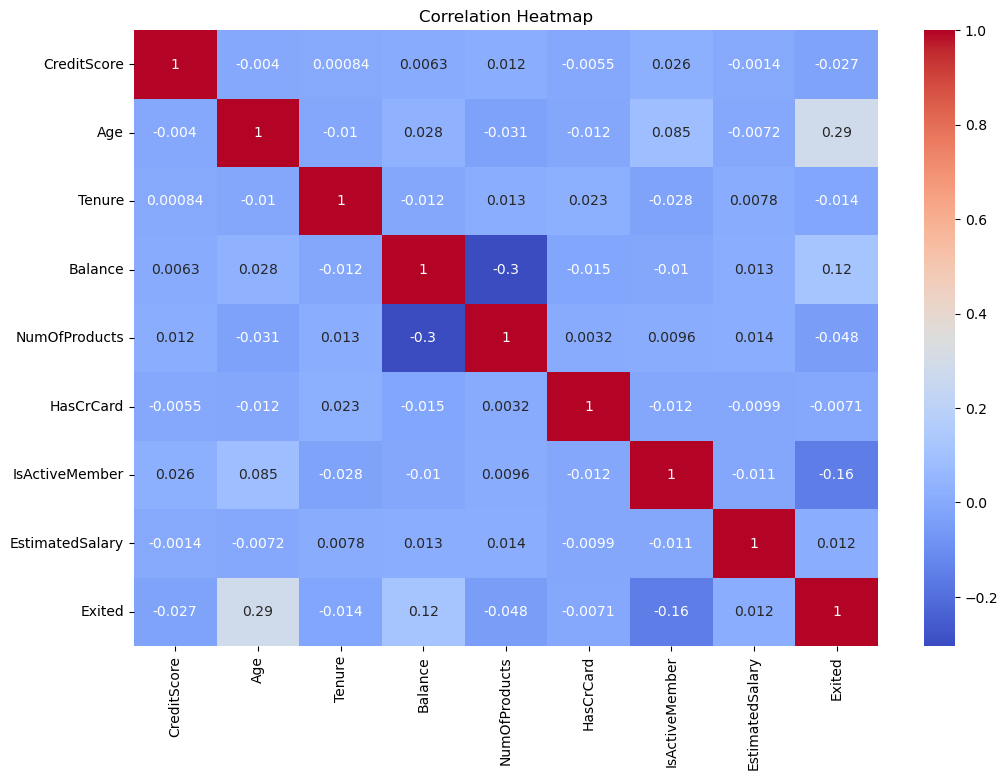

In [30]:
# Select only numeric columns for correlation heatmap
numeric_columns = customers.select_dtypes(include=[np.number])

# Create a correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap to explore factors contributing to churn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [31]:
print(correlation_matrix)

                 CreditScore       Age    Tenure   Balance  NumOfProducts  \
CreditScore         1.000000 -0.003965  0.000842  0.006268       0.012238   
Age                -0.003965  1.000000 -0.009997  0.028308      -0.030680   
Tenure              0.000842 -0.009997  1.000000 -0.012254       0.013444   
Balance             0.006268  0.028308 -0.012254  1.000000      -0.304180   
NumOfProducts       0.012238 -0.030680  0.013444 -0.304180       1.000000   
HasCrCard          -0.005458 -0.011721  0.022583 -0.014858       0.003183   
IsActiveMember      0.025651  0.085472 -0.028362 -0.010084       0.009612   
EstimatedSalary    -0.001384 -0.007201  0.007784  0.012797       0.014204   
Exited             -0.027094  0.285323 -0.014001  0.118533      -0.047820   

                 HasCrCard  IsActiveMember  EstimatedSalary    Exited  
CreditScore      -0.005458        0.025651        -0.001384 -0.027094  
Age              -0.011721        0.085472        -0.007201  0.285323  
Tenure       

**Age, Balance, and IsActiveMember** appear to be the most influential factors in predicting customer churn.

**CreditScore, Tenure, NumOfProducts**, and HasCrCard show weak correlations with churn.

The negative correlation for **IsActiveMember** suggests that engaged customers are less likely to churn.

<Axes: xlabel='Exited', ylabel='count'>

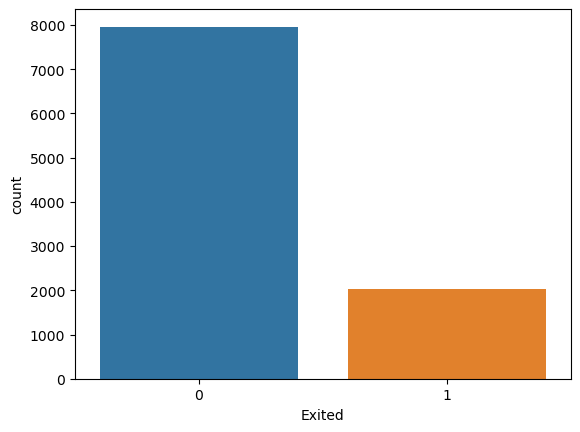

In [32]:
# Visualize churn distribution
sns.countplot(x='Exited', data=customers)

<Axes: xlabel='Geography', ylabel='count'>

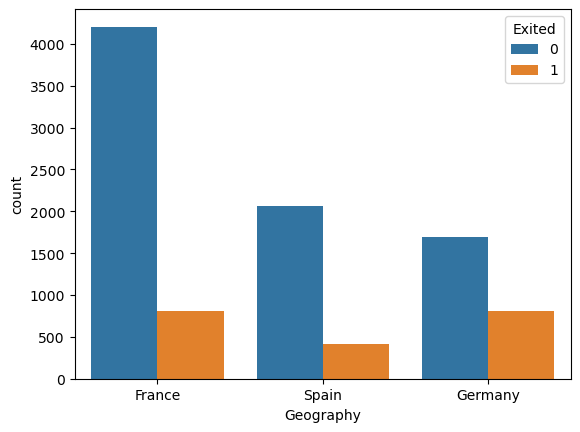

In [33]:
# Visualize categorical variables
sns.countplot(x='Geography', hue='Exited', data=customers)

<Axes: xlabel='Gender', ylabel='count'>

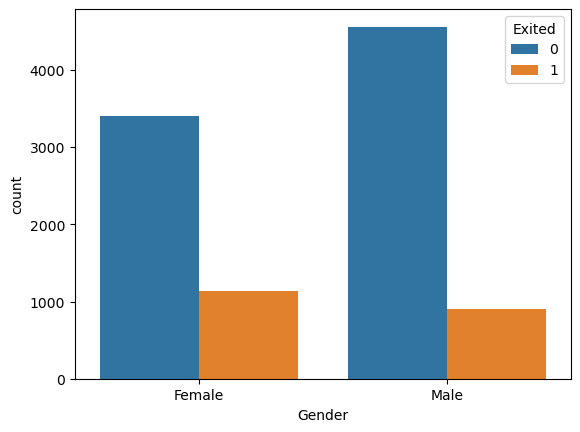

In [34]:
sns.countplot(x='Gender', hue='Exited', data=customers)

Using box plots to visualize the distribution of continuous variables like **Age** and **CreditScore** helps in understanding potential patterns and outliers.

<Axes: xlabel='Exited', ylabel='Age'>

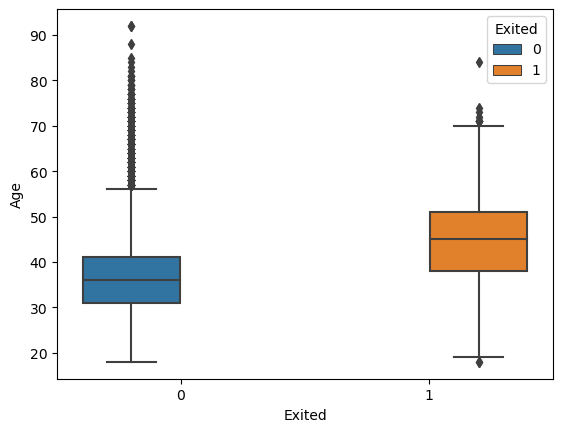

In [35]:
# Explore distribution of continuous variables
sns.boxplot(x='Exited', y='Age', hue='Exited', data=customers)

The older customers are churning more than the younger ones in the age categories.

<Axes: xlabel='Exited', ylabel='CreditScore'>

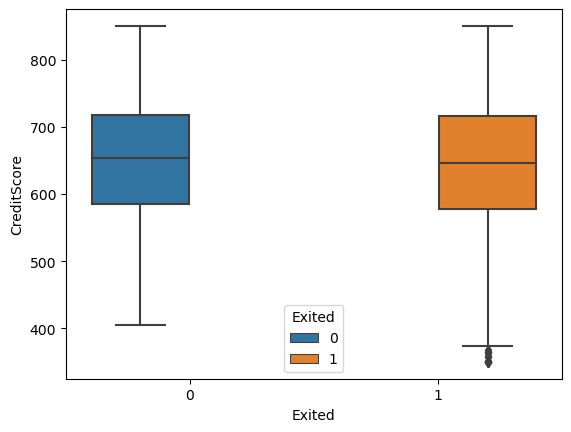

In [36]:
sns.boxplot(x='Exited', y='CreditScore', hue='Exited', data=customers)

There is no significant difference in the credit score distribution between retained and churned customers.

In [37]:
# Create new features
customers['BalanceSalaryRatio'] = customers['Balance'] / customers['EstimatedSalary']
customers['TenureAgeRatio'] = customers['Tenure'] / customers['Age']

In [38]:
# Define features and target variable
X = customers.drop('Exited', axis=1)
y = customers['Exited']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Data Preparation for Model Fitting

In [39]:
# Arrange columns by data type
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(include=[object]).columns

# Standardize numeric columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [40]:
# Convert categorical variables to numerical using one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

### Build Predictive Model

In [41]:
# Build a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

[[1550   57]
 [ 208  185]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000

Accuracy: 0.8675


The Random Forest Classifier demonstrates commendable performance in predicting customers who have not churned (class 0), achieving high precision, recall, and F1-score for this category. However, the model exhibits limitations in accurately identifying customers who have churned (class 1), as reflected by lower recall and F1-score for this class.

### Key Observations

**Positive Aspects**

The model excels in identifying customers who are likely to stay with the bank (class 0), showcasing strong precision, recall, and F1-score.
Overall accuracy is relatively high at 86.75%, indicating good general predictive performance.


**Areas for Improvement**

The model's performance is less satisfactory for identifying churned customers (class 1), where recall and F1-score are notably lower.
The imbalance in recall between the two classes suggests that the model might benefit from enhancements to better capture customers prone to churn.

### Hyperparameter tuning with GridSearchCV

In [42]:
# Employing GridSearchCV to find the best hyperparameters for the Random Forest model,
# optimizing its performance on the training data.
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_tuned = best_rf_model.predict(X_test)

# Evaluate the tuned model
# Evaluating the model using confusion matrix, classification report, and accuracy score
# to assess its performance on the test set.
print("\nTuned Model Evaluation:")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))


Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

Tuned Model Evaluation:
[[1546   61]
 [ 205  188]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.48      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000

Accuracy: 0.867


### Conclusion:


- The tuned model demonstrates improved performance compared to the initial model, with a weighted average F1-score of 85%.

- The model excels in predicting customers who do not churn (class 0) with high precision and recall.

- However, there is room for improvement in identifying customers who actually churn (class 1). The recall for class 1 is still relatively low, indicating that the model misses a significant portion of churned customers.
- Further model refinement or exploration of alternative techniques, such as ensemble methods or advanced algorithms, may be considered to address this specific challenge.

- The business implications of false negatives (customers predicted as not churning but actually do) should be carefully evaluated, as minimizing these instances might be crucial for a proactive churn prevention strategy.